# Performs FGSM, PGD attacks on various uncertainty measures that result in more misclassifications by the model 

(Non targetted attacks)

Adversarial success: 
  
  Prior to attack model predicts correct label for a sample (pred == truth_label)
  
  Under attack model predicts a different label for the sample (pred != truth_label)

In [1]:
import sys
import os
sys.path.append('/nfs/homedirs/giri/masterthesis')
os.chdir('/nfs/homedirs/giri/masterthesis')

In [2]:
import os
from PIL import Image
from IPython.display import display
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum
from robust_priornet.utils.visualizer import plot_adv_samples,plot_all_roc_curves, plot_all_pr_curves, plot_many_epsilon_curves
from robust_priornet.attack_priornet import plot_mis_adv_success

In [3]:
model_dir="runtime-model-vgg6-50epochs"
batch_size=64
data_dir="./runtime-data"
in_dataset="MNIST"

### Utils

In [4]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

In [5]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[], limit=None):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices, limit=limit)

    last_batch = misclassified_samples - (misclassified_samples%10) if limit is None else (limit-10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

## Attack on confidence (max probability of the predictive posterior)

In [6]:
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

### FGSM Attack

In [8]:
out_dir = model_dir+"/attack-fgsm"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm


In [ ]:
os.system(cmd)

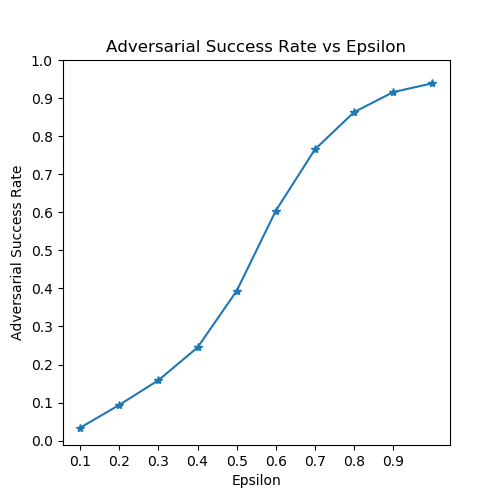

In [12]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-fgsm", "epsilon-curve.png"))
display(img)

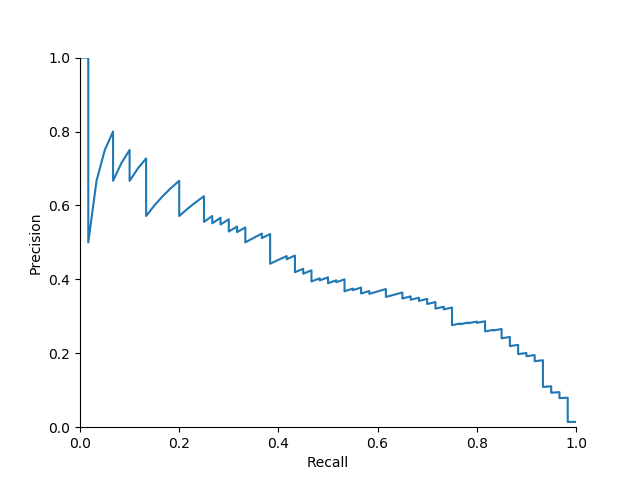

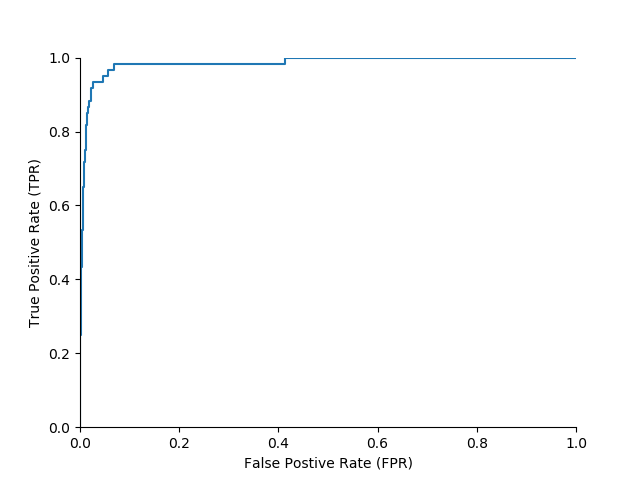

In [13]:
# model before attack
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

In [9]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-fgsm")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)

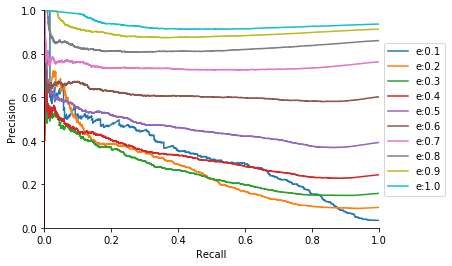

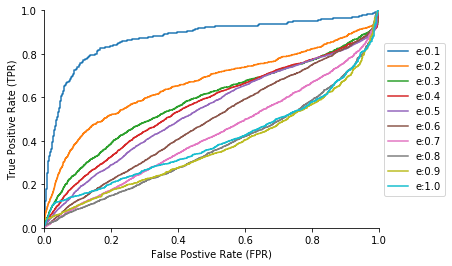

In [10]:
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

# Misclassified samples under attack:  3923
# old preds:  [7 2 1 ... 4 5 6]
# Correct classified samples prior attack:  9940
# Real adversarial samples under attack:  3911


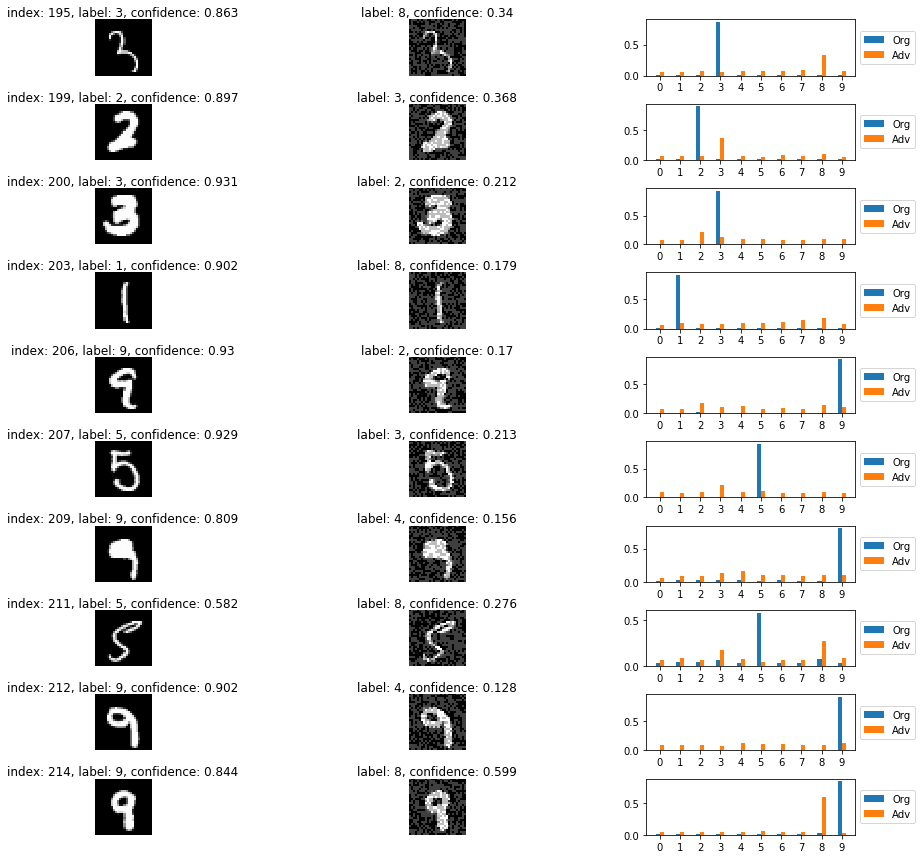

In [14]:
attack_dir=os.path.join(model_dir, "attack-fgsm")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.5, limit=100)

### PGD Attack L_infinity - steps=100, step_size= 1/10 * epsilon

In [7]:
out_dir = model_dir+"/attack-pgd-100steps"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type PGD --attack_criteria confidence --epsilon {epsilons} --max_steps 100 --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type PGD --attack_criteria confidence --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --max_steps 100 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-pgd-100steps


In [ ]:
os.system(cmd)

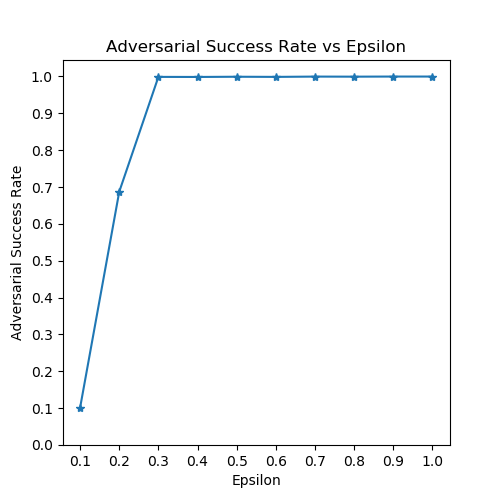

In [10]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-pgd-100steps", "epsilon-curve.png"))
display(img)

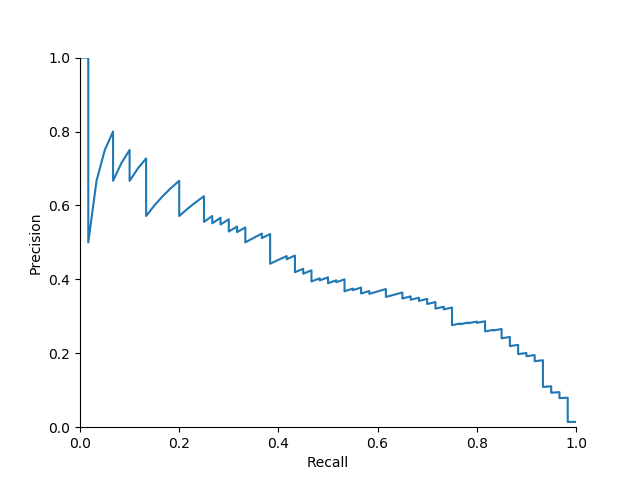

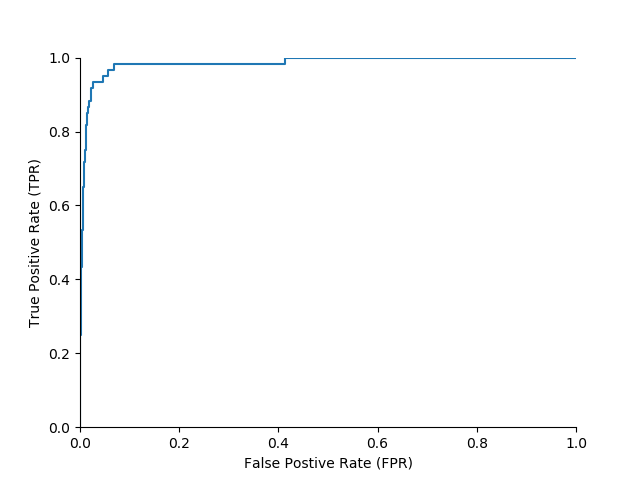

In [11]:
# model before attack
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

In [10]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-pgd-100steps")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)

# Note the PR curve is almost touching 100%, so the model is predicting as many mislcassifications as
# the correctly classified samples. (not the case for FGSM, so PGD is effective leading to more misclassifications)

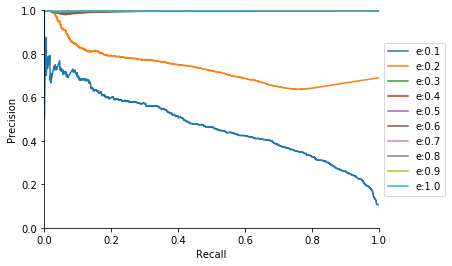

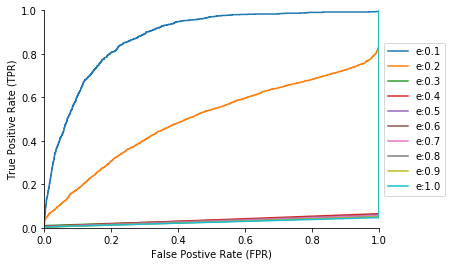

In [11]:
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

# Misclassified samples under attack:  9989
# Correct classified samples prior attack:  9940
# Real adversarial samples under attack:  9929


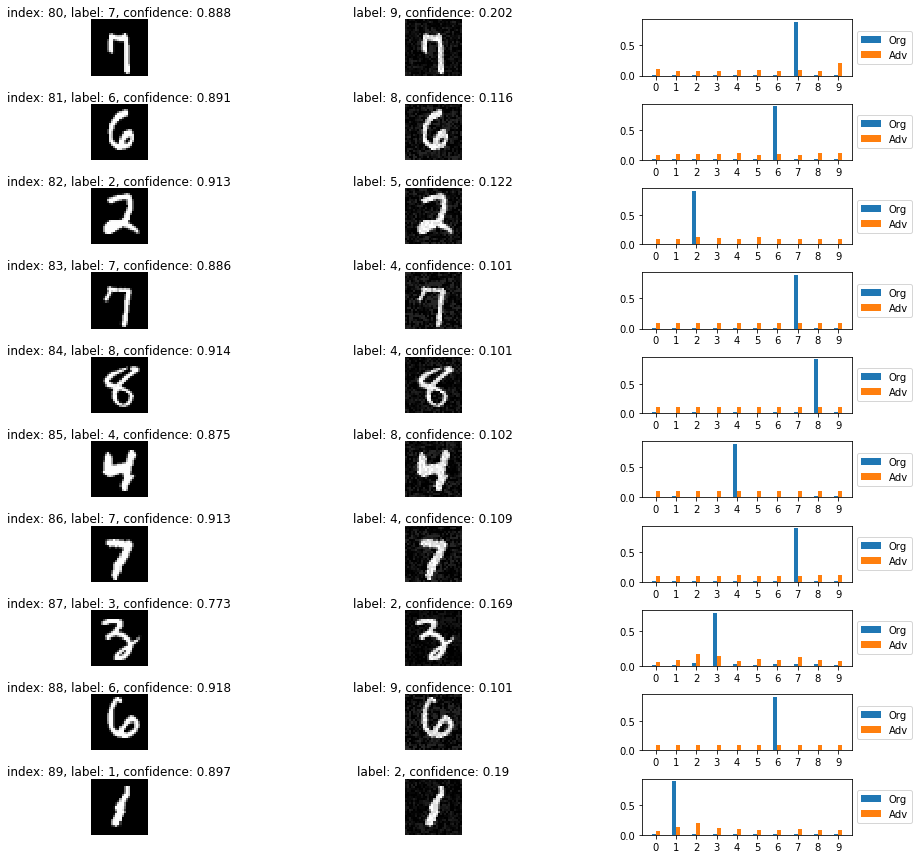

In [13]:
attack_dir=os.path.join(model_dir, "attack-pgd-100steps")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.3, limit=100)

### PGD Attack L_2 - steps=100, step_size= 1/10 * epsilon

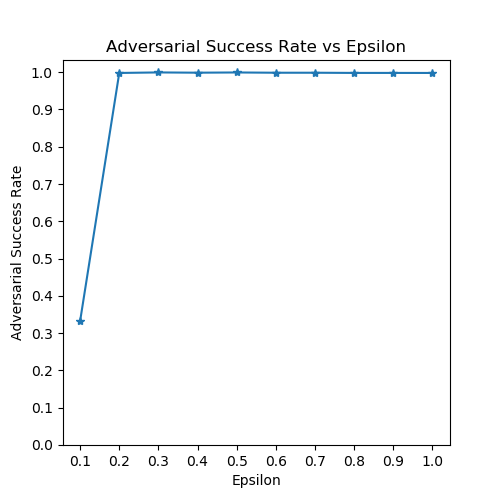

In [6]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-pgd-100steps-l2", "epsilon-curve.png"))
display(img)

In [12]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-pgd-100steps-l2")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)

# Note the PR curve is almost touching 100%, so the model is predicting as many mislcassifications as
# the correctly classified samples. (not the case for FGSM, so PGD is effective leading to more misclassifications)

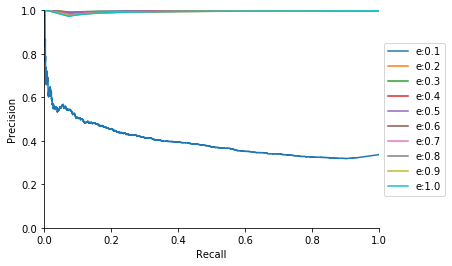

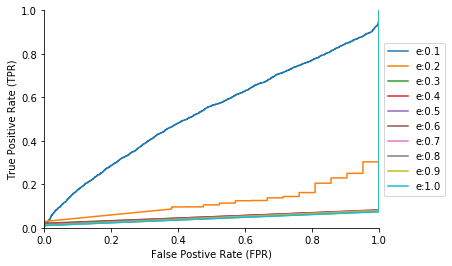

In [14]:
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

# Misclassified samples under attack:  9993
# Correct classified samples prior attack:  9940
# Real adversarial samples under attack:  9933


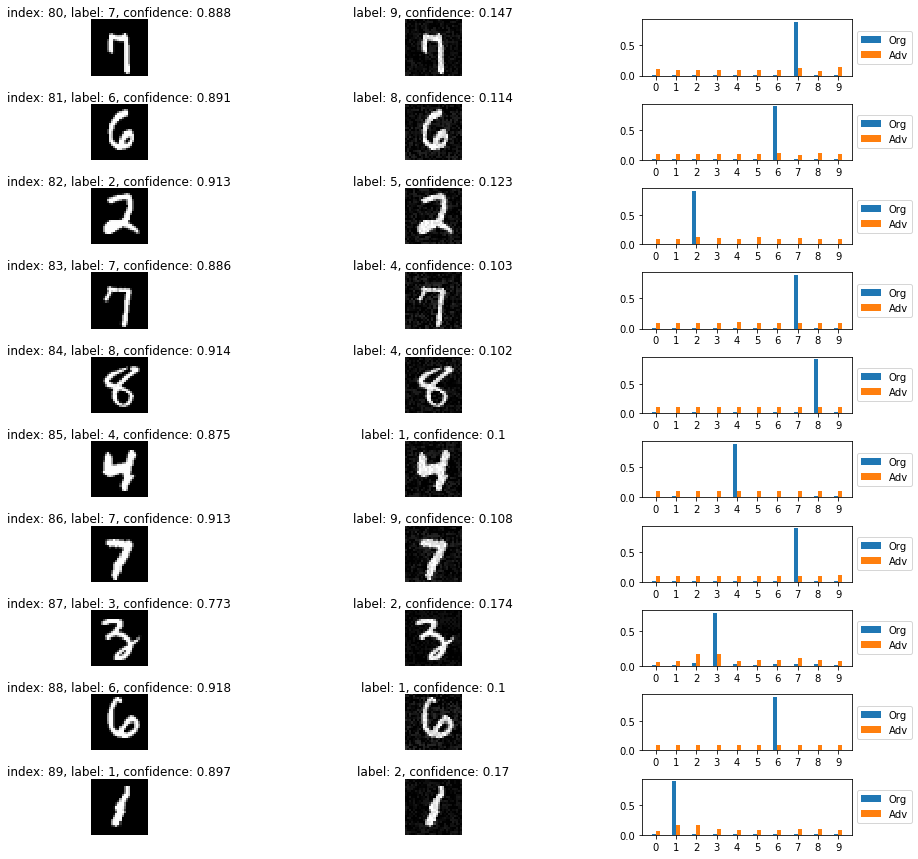

In [15]:
attack_dir=os.path.join(model_dir, "attack-pgd-100steps-l2")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.3, limit=100)

### Summary of Attacks on confidence 

In [ ]:
# comparison between L_infinity and L_2 PGD attacks
org_eval_dir = os.path.join(model_dir, 'eval')
os.makedirs(os.path.join(model_dir, 'epsilon-curve-comparison'))
mis_success_fgsm = plot_mis_adv_success(org_eval_dir, os.path.join(model_dir, "attack-fgsm"), epsilon_list, os.path.join(model_dir, 'epsilon-curve-comparison'))
mis_success_pgd_infinity_norm = plot_mis_adv_success(org_eval_dir, os.path.join(model_dir, "attack-pgd-100steps"), epsilon_list, os.path.join(model_dir, 'epsilon-curve-comparison'))
mis_success_pgd_l2_norm = plot_mis_adv_success(org_eval_dir, os.path.join(model_dir, "attack-pgd-100steps-l2"), epsilon_list, os.path.join(model_dir, 'epsilon-curve-comparison'))

plot_many_epsilon_curves(epsilon_list, [mis_success_fgsm, mis_success_pgd_infinity_norm, mis_success_pgd_l2_norm], ['FGSM L_infinity attack', 'PGD L_infinity attack', 'PGD L_2 attack'], 'Confidence attack - MNIST (test set)', model_dir, 'misclassification-conf-epsilon-summary.png')


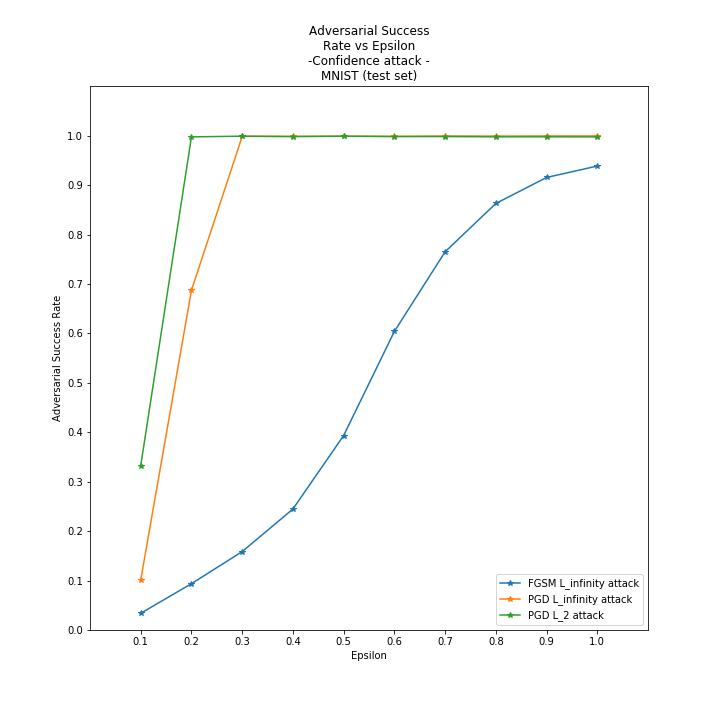

In [9]:
display(Image.open(os.path.join(model_dir, 'misclassification-conf-epsilon-summary.png')))

## Attack on total_uncertainty (entropy of the expected categorical dist)

In [5]:
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

### FGSM Attack

In [9]:
out_dir = model_dir+"/attack-fgsm-total_uncertainty"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria entropy_of_exp --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria entropy_of_exp --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm-total_uncertainty


In [10]:
os.system(cmd)

0

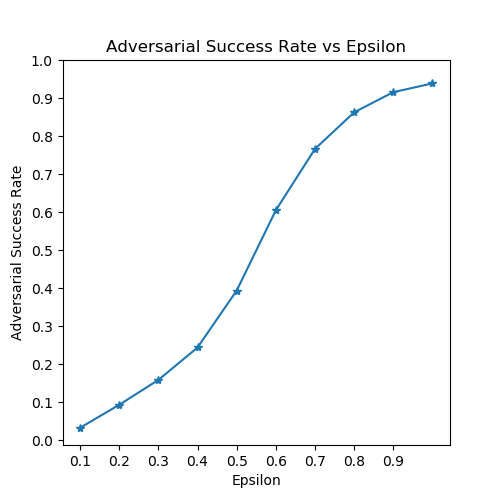

In [6]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-fgsm-total_uncertainty", "epsilon-curve.png"))
display(img)

## looks almost similar to the epsilon curve for confidence loss attack, as we are just using the sign of the gradient
## and both -1*confidence and total_uncertainty will point in same direction
## and verified the overall results for both attacks, numbers are not the same but only close enough

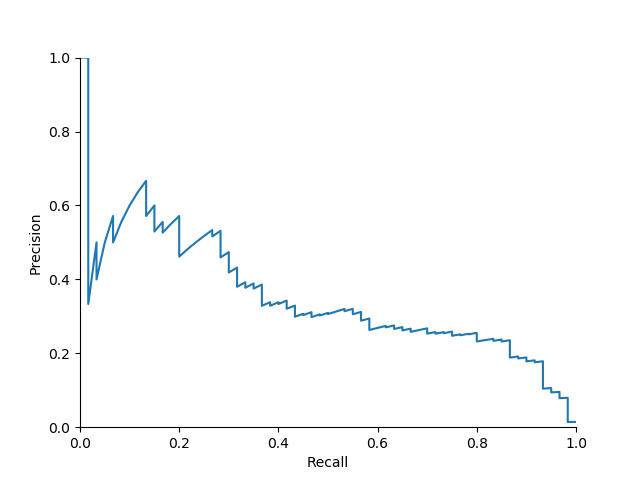

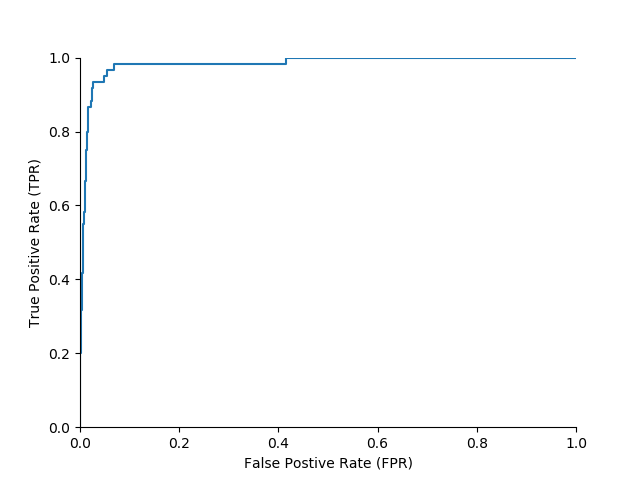

In [8]:
# model before attack
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.TOTAL_UNCERTAINTY)

In [16]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-fgsm-total_uncertainty")
measure = UncertaintyMeasuresEnum.TOTAL_UNCERTAINTY
plot_all_roc_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)

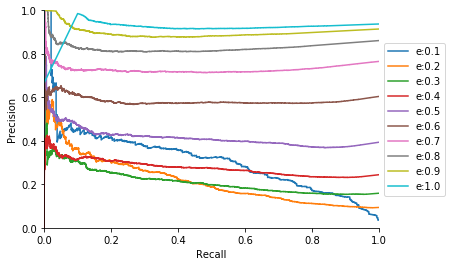

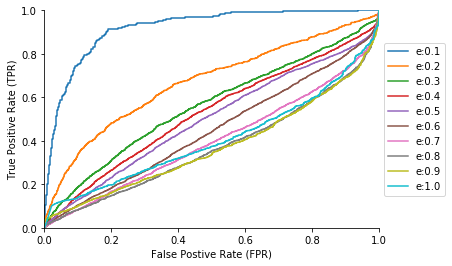

In [17]:
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

# Misclassified samples under attack:  1590
# Correct classified samples prior attack:  9940
# Real adversarial samples under attack:  1572


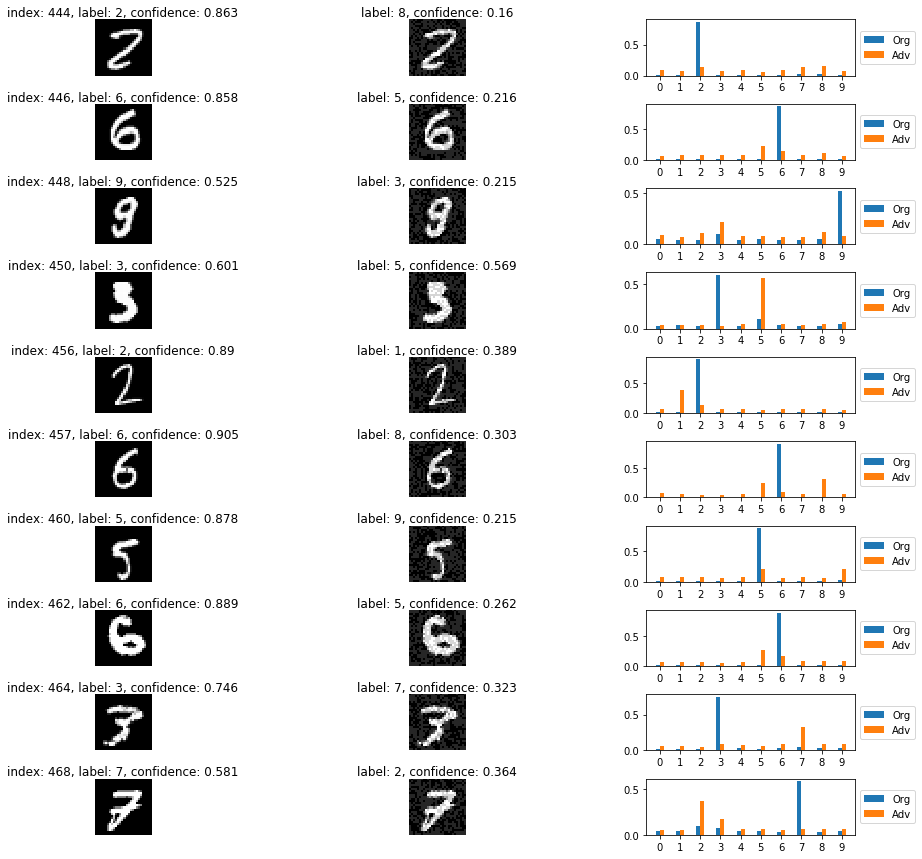

In [8]:
attack_dir=os.path.join(model_dir, "attack-fgsm-total_uncertainty")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.3, limit=100)

### PGD Attack

## Attack on expected_data_uncertainty (expected entropy)

In [15]:
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

### FGSM Attack

In [17]:
out_dir = model_dir+"/attack-fgsm-expected_data_uncertainty"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria exp_entropy --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria exp_entropy --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm-expected_data_uncertainty


In [18]:
os.system(cmd)

0

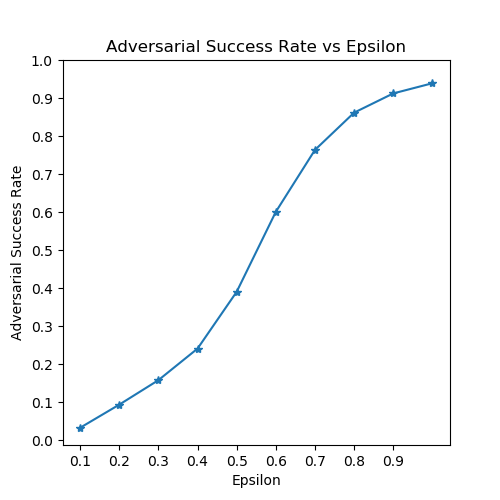

In [19]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-fgsm-expected_data_uncertainty", "epsilon-curve.png"))
display(img)

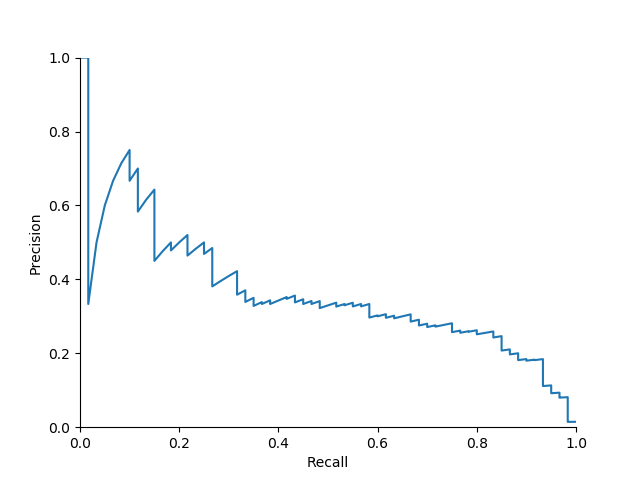

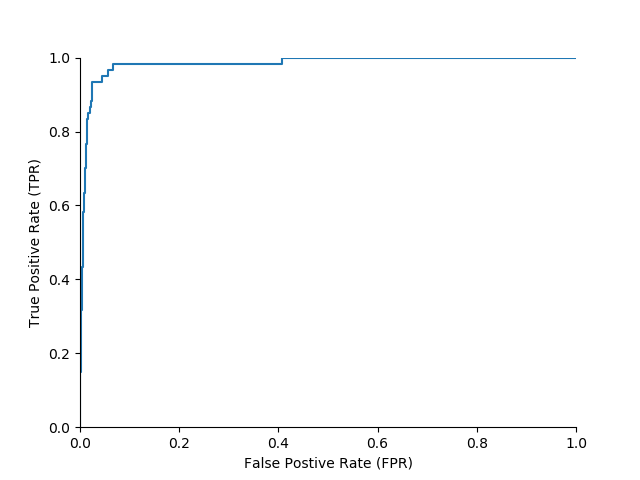

In [20]:
# model before attack
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.EXPECTED_DATA_UNCERTAINTY)

In [18]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-fgsm-expected_data_uncertainty")
measure = UncertaintyMeasuresEnum.EXPECTED_DATA_UNCERTAINTY
plot_all_roc_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)

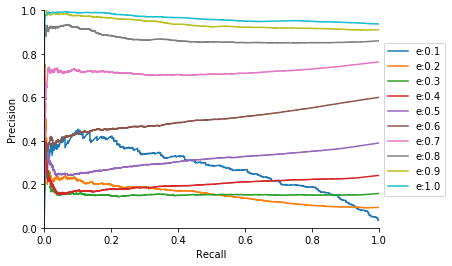

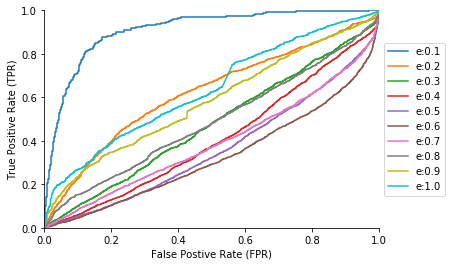

In [19]:
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

# Misclassified samples under attack:  1582
# Correct classified samples prior attack:  9940
# Real adversarial samples under attack:  1568


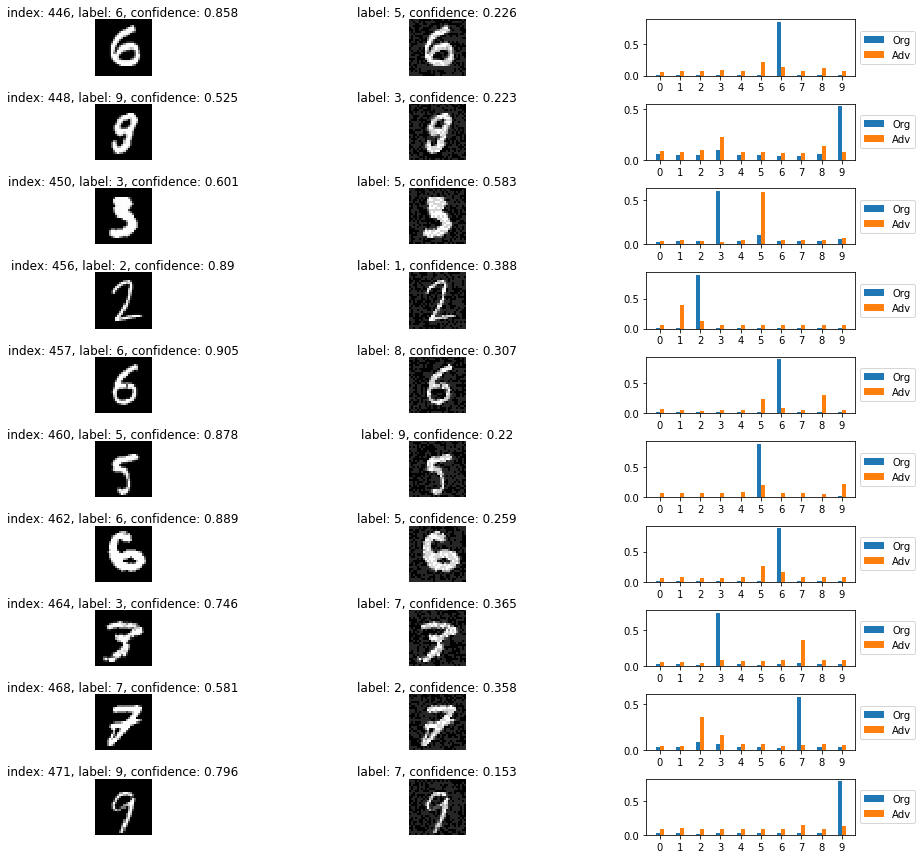

In [9]:
attack_dir=os.path.join(model_dir, "attack-fgsm-expected_data_uncertainty")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.3, limit=100)